In [1]:
import torch
import torch.nn as nn
import torchvision
from fld.features.InceptionFeatureExtractor import InceptionFeatureExtractor
from fld.metrics.FLD import FLD
from fld.metrics.FID import FID
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

from fld.features.DINOv2FeatureExtractor import DINOv2FeatureExtractor
from fld.features.InceptionFeatureExtractor import InceptionFeatureExtractor
from fld.features.CLIPFeatureExtractor import CLIPFeatureExtractor
from fld.metrics.FLD import FLD
from fld.metrics.FID import FID

In [2]:
import torch
print(torch.cuda.is_available())  #  return True if CUDA is enabled
print(torch.version.cuda)  #  show the CUDA version PyTorch was compiled with
print(torch.cuda.device_count())  # Number of available GPUs
print(torch.cuda.get_device_name(0))  # Name of your GPU (if available)


True
12.1
1
NVIDIA GeForce RTX 3060 Laptop GPU


In [3]:
# ----------------------
# Step 4: Load Datasets (CIFAR-10)
# ----------------------

train_dataset = torchvision.datasets.CIFAR10(root=r"D:\ift6164\data", train=True, download=True)
train_dataset.name = "CIFAR10_train"  # Dataset needs a name to cache features

test_dataset = torchvision.datasets.CIFAR10(root=r"D:\ift6164\data", train=False, download=True)
test_dataset.name = "CIFAR10_test"


Files already downloaded and verified
Files already downloaded and verified


In [4]:
# ----------------------
# Step 4: Load GENERATED Datasets (CIFAR)
# ----------------------

# Path to generated CIFAR-10 images
generated_images_path = "D:/ift6164/gen_data/ckpt_pgfmpp"
# Load generated CIFAR-10 dataset 
generated_dataset = ImageFolder(root=generated_images_path)
generated_dataset.name = "Generated_pgfmpp_CIFAR10"

In [5]:
feature_extractor_D = DINOv2FeatureExtractor()

Using cache found in C:\Users\oumni/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\oumni/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\oumni/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\oumni/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [6]:
## define minor transformations
def apply_gaussian_blur(img):
    """Apply a minor Gaussian Blur"""
    return transforms.GaussianBlur(kernel_size=1, sigma=(0.0008, 0.002))(img)

def apply_posterize(img):
    """Reduce color depth to simulate posterization"""
    return transforms.functional.posterize(img, bits=6)

def apply_jpeg_compression_75(img, quality=75):
    """Save and reload image with JPEG compression"""
    img_pil = img.convert("RGB")  # Convert to RGB mode if needed
    img_pil.save("temp.jpg", "JPEG", quality=quality, optimize=True)
    return Image.open("temp.jpg").convert("RGB")

def apply_jpeg_compression_90(img, quality=90):
    """Save and reload image with JPEG compression"""
    img_pil = img.convert("RGB")  # Convert to RGB mode if needed
    img_pil.save("temp.jpg", "JPEG", quality=quality, optimize=True)
    return Image.open("temp.jpg").convert("RGB")

def apply_resize(img):
    new_size = (int(img.size[0] * 0.75), int(img.size[1] * 0.75))
    return img.resize(new_size, Image.BICUBIC)


## define  major transformations
def apply_color_distortion(img):
    """Randomly adjust brightness, contrast, saturation, and hue"""
    return transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)(img)

def apply_center_crop_30(img):
    """Crop the center region of the image"""
    #return transforms.CenterCrop(size=(img.size[0] // 2, img.size[1] // 2))(img)
    return transforms.CenterCrop(size=(img.size[0] * 0.3 , img.size[1] * 0.3))(img)

def apply_center_crop_28(img):
    """Crop the center region of the image"""
    #return transforms.CenterCrop(size=(img.size[0] // 2, img.size[1] // 2))(img)
    return transforms.CenterCrop(size=(img.size[0] * 0.28 , img.size[1] * 0.28))(img)


def apply_elastic_transform(img):
    """Apply elastic deformation (requires torchvision >= 0.11.0)"""
    return transforms.ElasticTransform(alpha=25.0)(img)


# Define the transformation dictionary
all_transforms = {
    "Gaussian Blur": apply_gaussian_blur,
    "Posterize": apply_posterize,
    "JPG 75": lambda img: apply_jpeg_compression_75(img),
    "JPG 90": lambda img: apply_jpeg_compression_90(img),
    "Resize": apply_resize,
    "Color Distort": apply_color_distortion,
    "Center Crop 30": apply_center_crop_30,
    "Center Crop 28": apply_center_crop_28,
    "Elastic Transform": apply_elastic_transform
}

In [7]:
# Function to apply transformations to a dataset
def apply_transformations(dataset, transform_dict):
    transformed_datasets = {}
    for name, transform in transform_dict.items():
        #transformed_datasets[name] = [transform(img) for img in dataset]
        transformed_datasets[name] = [transform(img[0] if isinstance(img, tuple) else img) for img in dataset]
    return transformed_datasets

In [8]:
transformed_images = apply_transformations(generated_dataset, all_transforms)

In [ ]:
feature_extractor_D = DINOv2FeatureExtractor()

In [22]:
train_feat_D = feature_extractor_D.get_dataset_features(train_dataset)

In [23]:
test_feat_D = feature_extractor_D.get_dataset_features(test_dataset)

In [9]:
gen_feat_D = feature_extractor_D.get_dataset_features(generated_dataset) 

In [12]:
# Minimal dataset wrapper for transformed images
class TransformedDataset(Dataset):
    def __init__(self, images):
        self.images = images  # List of images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], 0  # Dummy label

# Extract features for each transformed dataset
def extract_features(transformed_datasets):
    return {name: feature_extractor_D.get_dataset_features(TransformedDataset(images))
            for name, images in transformed_datasets.items()}

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch
import numpy as np
import torchvision.transforms as transforms


DINO_INPUT_SIZE = 224

# Minimal dataset wrapper for transformed images
class TransformedDataset(Dataset):
    def __init__(self, images):
        self.transform = transforms.Compose([
            transforms.Resize((DINO_INPUT_SIZE, DINO_INPUT_SIZE)),  # Resize to match model
            transforms.ToTensor()  # Convert to tensor
        ])
        self.images = [self.transform(img) for img in images]  # Apply transformations

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], 0  # Return (image, dummy label) tuple

# Function to extract features with batch processing and resizing
def extract_features(transformed_datasets, feature_extractor, batch_size=32):
    transformed_features = {}

    for name, images in transformed_datasets.items():
        print(f"\n[INFO] Extracting features for: {name} ({len(images)} images)")

        dataset = TransformedDataset(images)  # Convert image list to dataset
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

        features_list = []
        
        for batch_idx, (img_batch, _) in enumerate(tqdm(dataloader, desc=f"Processing {name}", leave=True)):
            img_batch = img_batch.to("cuda" if torch.cuda.is_available() else "cpu")  # Move to GPU if available
            
            # Extract features for the batch
            batch_features = feature_extractor.get_feature_batch(img_batch)
            features_list.append(batch_features.cpu().numpy())

            # Print progress every 10 batches
            if batch_idx % 10 == 0:
                print(f" - Processed {batch_idx * batch_size}/{len(images)} images for {name}")

        # Combine all batches into a single feature matrix
        transformed_features[name] = np.vstack(features_list)

    return transformed_features



In [13]:
transformed_feats_D = extract_features(transformed_images, feature_extractor_D, batch_size=32)


[INFO] Extracting features for: Gaussian Blur (10089 images)


Processing Gaussian Blur:   0%|          | 1/316 [00:00<03:26,  1.53it/s]

 - Processed 0/10089 images for Gaussian Blur


Processing Gaussian Blur:   3%|▎         | 11/316 [00:04<01:43,  2.93it/s]

 - Processed 320/10089 images for Gaussian Blur


Processing Gaussian Blur:   7%|▋         | 21/316 [00:07<01:31,  3.21it/s]

 - Processed 640/10089 images for Gaussian Blur


Processing Gaussian Blur:  10%|▉         | 31/316 [00:10<01:25,  3.33it/s]

 - Processed 960/10089 images for Gaussian Blur


Processing Gaussian Blur:  13%|█▎        | 41/316 [00:13<01:23,  3.31it/s]

 - Processed 1280/10089 images for Gaussian Blur


Processing Gaussian Blur:  16%|█▌        | 51/316 [00:16<01:20,  3.28it/s]

 - Processed 1600/10089 images for Gaussian Blur


Processing Gaussian Blur:  19%|█▉        | 61/316 [00:19<01:17,  3.29it/s]

 - Processed 1920/10089 images for Gaussian Blur


Processing Gaussian Blur:  22%|██▏       | 71/316 [00:22<01:14,  3.30it/s]

 - Processed 2240/10089 images for Gaussian Blur


Processing Gaussian Blur:  26%|██▌       | 81/316 [00:26<01:51,  2.10it/s]

 - Processed 2560/10089 images for Gaussian Blur


Processing Gaussian Blur:  29%|██▉       | 91/316 [00:31<01:52,  2.01it/s]

 - Processed 2880/10089 images for Gaussian Blur


Processing Gaussian Blur:  32%|███▏      | 101/316 [00:36<01:57,  1.83it/s]

 - Processed 3200/10089 images for Gaussian Blur


Processing Gaussian Blur:  35%|███▌      | 111/316 [00:42<01:56,  1.76it/s]

 - Processed 3520/10089 images for Gaussian Blur


Processing Gaussian Blur:  38%|███▊      | 121/316 [00:48<01:50,  1.76it/s]

 - Processed 3840/10089 images for Gaussian Blur


Processing Gaussian Blur:  41%|████▏     | 131/316 [00:54<01:42,  1.81it/s]

 - Processed 4160/10089 images for Gaussian Blur


Processing Gaussian Blur:  45%|████▍     | 141/316 [00:59<01:36,  1.82it/s]

 - Processed 4480/10089 images for Gaussian Blur


Processing Gaussian Blur:  48%|████▊     | 151/316 [01:03<01:03,  2.60it/s]

 - Processed 4800/10089 images for Gaussian Blur


Processing Gaussian Blur:  51%|█████     | 161/316 [01:07<00:54,  2.85it/s]

 - Processed 5120/10089 images for Gaussian Blur


Processing Gaussian Blur:  54%|█████▍    | 171/316 [01:10<00:48,  3.00it/s]

 - Processed 5440/10089 images for Gaussian Blur


Processing Gaussian Blur:  57%|█████▋    | 181/316 [01:14<00:45,  2.99it/s]

 - Processed 5760/10089 images for Gaussian Blur


Processing Gaussian Blur:  60%|██████    | 191/316 [01:17<00:40,  3.09it/s]

 - Processed 6080/10089 images for Gaussian Blur


Processing Gaussian Blur:  64%|██████▎   | 201/316 [01:20<00:37,  3.04it/s]

 - Processed 6400/10089 images for Gaussian Blur


Processing Gaussian Blur:  67%|██████▋   | 211/316 [01:23<00:34,  3.00it/s]

 - Processed 6720/10089 images for Gaussian Blur


Processing Gaussian Blur:  70%|██████▉   | 221/316 [01:27<00:34,  2.74it/s]

 - Processed 7040/10089 images for Gaussian Blur


Processing Gaussian Blur:  73%|███████▎  | 231/316 [01:30<00:28,  2.94it/s]

 - Processed 7360/10089 images for Gaussian Blur


Processing Gaussian Blur:  76%|███████▋  | 241/316 [01:34<00:27,  2.74it/s]

 - Processed 7680/10089 images for Gaussian Blur


Processing Gaussian Blur:  79%|███████▉  | 251/316 [01:38<00:24,  2.68it/s]

 - Processed 8000/10089 images for Gaussian Blur


Processing Gaussian Blur:  83%|████████▎ | 261/316 [01:41<00:18,  2.95it/s]

 - Processed 8320/10089 images for Gaussian Blur


Processing Gaussian Blur:  86%|████████▌ | 271/316 [01:45<00:15,  2.93it/s]

 - Processed 8640/10089 images for Gaussian Blur


Processing Gaussian Blur:  89%|████████▉ | 281/316 [01:48<00:13,  2.67it/s]

 - Processed 8960/10089 images for Gaussian Blur


Processing Gaussian Blur:  92%|█████████▏| 291/316 [01:52<00:10,  2.27it/s]

 - Processed 9280/10089 images for Gaussian Blur


Processing Gaussian Blur:  95%|█████████▌| 301/316 [01:57<00:06,  2.34it/s]

 - Processed 9600/10089 images for Gaussian Blur


Processing Gaussian Blur:  98%|█████████▊| 311/316 [02:01<00:02,  2.34it/s]

 - Processed 9920/10089 images for Gaussian Blur


Processing Gaussian Blur: 100%|██████████| 316/316 [02:03<00:00,  2.56it/s]



[INFO] Extracting features for: Posterize (10089 images)


Processing Posterize:   0%|          | 1/316 [00:00<04:11,  1.25it/s]

 - Processed 0/10089 images for Posterize


Processing Posterize:   3%|▎         | 11/316 [00:05<02:32,  2.00it/s]

 - Processed 320/10089 images for Posterize


Processing Posterize:   7%|▋         | 21/316 [00:09<01:42,  2.87it/s]

 - Processed 640/10089 images for Posterize


Processing Posterize:  10%|▉         | 31/316 [00:12<01:28,  3.21it/s]

 - Processed 960/10089 images for Posterize


Processing Posterize:  13%|█▎        | 41/316 [00:15<01:26,  3.19it/s]

 - Processed 1280/10089 images for Posterize


Processing Posterize:  16%|█▌        | 51/316 [00:19<01:20,  3.29it/s]

 - Processed 1600/10089 images for Posterize


Processing Posterize:  19%|█▉        | 61/316 [00:22<01:17,  3.30it/s]

 - Processed 1920/10089 images for Posterize


Processing Posterize:  22%|██▏       | 71/316 [00:25<01:14,  3.30it/s]

 - Processed 2240/10089 images for Posterize


Processing Posterize:  26%|██▌       | 81/316 [00:28<01:11,  3.30it/s]

 - Processed 2560/10089 images for Posterize


Processing Posterize:  29%|██▉       | 91/316 [00:31<01:08,  3.28it/s]

 - Processed 2880/10089 images for Posterize


Processing Posterize:  32%|███▏      | 101/316 [00:34<01:06,  3.24it/s]

 - Processed 3200/10089 images for Posterize


Processing Posterize:  35%|███▌      | 111/316 [00:37<01:05,  3.14it/s]

 - Processed 3520/10089 images for Posterize


Processing Posterize:  38%|███▊      | 121/316 [00:40<01:02,  3.12it/s]

 - Processed 3840/10089 images for Posterize


Processing Posterize:  41%|████▏     | 131/316 [00:43<01:01,  3.02it/s]

 - Processed 4160/10089 images for Posterize


Processing Posterize:  45%|████▍     | 141/316 [00:47<00:59,  2.93it/s]

 - Processed 4480/10089 images for Posterize


Processing Posterize:  48%|████▊     | 151/316 [00:50<00:56,  2.93it/s]

 - Processed 4800/10089 images for Posterize


Processing Posterize:  51%|█████     | 161/316 [00:54<00:55,  2.82it/s]

 - Processed 5120/10089 images for Posterize


Processing Posterize:  54%|█████▍    | 171/316 [00:57<00:53,  2.74it/s]

 - Processed 5440/10089 images for Posterize


Processing Posterize:  57%|█████▋    | 181/316 [01:01<00:49,  2.72it/s]

 - Processed 5760/10089 images for Posterize


Processing Posterize:  60%|██████    | 191/316 [01:05<00:47,  2.63it/s]

 - Processed 6080/10089 images for Posterize


Processing Posterize:  64%|██████▎   | 201/316 [01:09<00:43,  2.61it/s]

 - Processed 6400/10089 images for Posterize


Processing Posterize:  67%|██████▋   | 211/316 [01:12<00:39,  2.67it/s]

 - Processed 6720/10089 images for Posterize


Processing Posterize:  70%|██████▉   | 221/316 [01:16<00:36,  2.60it/s]

 - Processed 7040/10089 images for Posterize


Processing Posterize:  73%|███████▎  | 231/316 [01:20<00:32,  2.65it/s]

 - Processed 7360/10089 images for Posterize


Processing Posterize:  76%|███████▋  | 241/316 [01:24<00:28,  2.62it/s]

 - Processed 7680/10089 images for Posterize


Processing Posterize:  79%|███████▉  | 251/316 [01:28<00:24,  2.61it/s]

 - Processed 8000/10089 images for Posterize


Processing Posterize:  83%|████████▎ | 261/316 [01:32<00:22,  2.47it/s]

 - Processed 8320/10089 images for Posterize


Processing Posterize:  86%|████████▌ | 271/316 [01:36<00:18,  2.43it/s]

 - Processed 8640/10089 images for Posterize


Processing Posterize:  89%|████████▉ | 281/316 [01:40<00:13,  2.56it/s]

 - Processed 8960/10089 images for Posterize


Processing Posterize:  92%|█████████▏| 291/316 [01:44<00:09,  2.58it/s]

 - Processed 9280/10089 images for Posterize


Processing Posterize:  95%|█████████▌| 301/316 [01:47<00:05,  2.58it/s]

 - Processed 9600/10089 images for Posterize


Processing Posterize:  98%|█████████▊| 311/316 [01:51<00:01,  2.58it/s]

 - Processed 9920/10089 images for Posterize


Processing Posterize: 100%|██████████| 316/316 [01:53<00:00,  2.78it/s]



[INFO] Extracting features for: JPG 75 (10089 images)


Processing JPG 75:   0%|          | 1/316 [00:00<04:32,  1.15it/s]

 - Processed 0/10089 images for JPG 75


Processing JPG 75:   3%|▎         | 11/316 [00:06<02:39,  1.91it/s]

 - Processed 320/10089 images for JPG 75


Processing JPG 75:   7%|▋         | 21/316 [00:09<01:38,  3.00it/s]

 - Processed 640/10089 images for JPG 75


Processing JPG 75:  10%|▉         | 31/316 [00:12<01:27,  3.26it/s]

 - Processed 960/10089 images for JPG 75


Processing JPG 75:  13%|█▎        | 41/316 [00:15<01:23,  3.31it/s]

 - Processed 1280/10089 images for JPG 75


Processing JPG 75:  16%|█▌        | 51/316 [00:18<01:21,  3.25it/s]

 - Processed 1600/10089 images for JPG 75


Processing JPG 75:  19%|█▉        | 61/316 [00:22<01:23,  3.05it/s]

 - Processed 1920/10089 images for JPG 75


Processing JPG 75:  22%|██▏       | 71/316 [00:25<01:20,  3.06it/s]

 - Processed 2240/10089 images for JPG 75


Processing JPG 75:  26%|██▌       | 81/316 [00:28<01:21,  2.89it/s]

 - Processed 2560/10089 images for JPG 75


Processing JPG 75:  29%|██▉       | 91/316 [00:32<01:18,  2.88it/s]

 - Processed 2880/10089 images for JPG 75


Processing JPG 75:  32%|███▏      | 101/316 [00:35<01:17,  2.78it/s]

 - Processed 3200/10089 images for JPG 75


Processing JPG 75:  35%|███▌      | 111/316 [00:39<01:15,  2.72it/s]

 - Processed 3520/10089 images for JPG 75


Processing JPG 75:  38%|███▊      | 121/316 [00:43<01:14,  2.61it/s]

 - Processed 3840/10089 images for JPG 75


Processing JPG 75:  41%|████▏     | 131/316 [00:47<01:10,  2.64it/s]

 - Processed 4160/10089 images for JPG 75


Processing JPG 75:  45%|████▍     | 141/316 [00:50<01:05,  2.66it/s]

 - Processed 4480/10089 images for JPG 75


Processing JPG 75:  48%|████▊     | 151/316 [00:54<01:04,  2.55it/s]

 - Processed 4800/10089 images for JPG 75


Processing JPG 75:  51%|█████     | 161/316 [00:58<01:01,  2.54it/s]

 - Processed 5120/10089 images for JPG 75


Processing JPG 75:  54%|█████▍    | 171/316 [01:02<00:57,  2.54it/s]

 - Processed 5440/10089 images for JPG 75


Processing JPG 75:  57%|█████▋    | 181/316 [01:06<00:53,  2.54it/s]

 - Processed 5760/10089 images for JPG 75


Processing JPG 75:  60%|██████    | 191/316 [01:10<00:49,  2.54it/s]

 - Processed 6080/10089 images for JPG 75


Processing JPG 75:  64%|██████▎   | 201/316 [01:14<00:47,  2.43it/s]

 - Processed 6400/10089 images for JPG 75


Processing JPG 75:  67%|██████▋   | 211/316 [01:18<00:43,  2.41it/s]

 - Processed 6720/10089 images for JPG 75


Processing JPG 75:  70%|██████▉   | 221/316 [01:22<00:38,  2.44it/s]

 - Processed 7040/10089 images for JPG 75


Processing JPG 75:  73%|███████▎  | 231/316 [01:26<00:34,  2.46it/s]

 - Processed 7360/10089 images for JPG 75


Processing JPG 75:  76%|███████▋  | 241/316 [01:30<00:30,  2.47it/s]

 - Processed 7680/10089 images for JPG 75


Processing JPG 75:  79%|███████▉  | 251/316 [01:35<00:26,  2.47it/s]

 - Processed 8000/10089 images for JPG 75


Processing JPG 75:  83%|████████▎ | 261/316 [01:39<00:22,  2.46it/s]

 - Processed 8320/10089 images for JPG 75


Processing JPG 75:  86%|████████▌ | 271/316 [01:43<00:18,  2.47it/s]

 - Processed 8640/10089 images for JPG 75


Processing JPG 75:  89%|████████▉ | 281/316 [01:47<00:14,  2.46it/s]

 - Processed 8960/10089 images for JPG 75


Processing JPG 75:  92%|█████████▏| 291/316 [01:51<00:10,  2.46it/s]

 - Processed 9280/10089 images for JPG 75


Processing JPG 75:  95%|█████████▌| 301/316 [01:55<00:06,  2.46it/s]

 - Processed 9600/10089 images for JPG 75


Processing JPG 75:  98%|█████████▊| 311/316 [01:59<00:02,  2.46it/s]

 - Processed 9920/10089 images for JPG 75


Processing JPG 75: 100%|██████████| 316/316 [02:01<00:00,  2.61it/s]



[INFO] Extracting features for: JPG 90 (10089 images)


Processing JPG 90:   0%|          | 1/316 [00:00<04:26,  1.18it/s]

 - Processed 0/10089 images for JPG 90


Processing JPG 90:   3%|▎         | 11/316 [00:06<02:41,  1.88it/s]

 - Processed 320/10089 images for JPG 90


Processing JPG 90:   7%|▋         | 21/316 [00:10<01:45,  2.81it/s]

 - Processed 640/10089 images for JPG 90


Processing JPG 90:  10%|▉         | 31/316 [00:13<01:31,  3.12it/s]

 - Processed 960/10089 images for JPG 90


Processing JPG 90:  13%|█▎        | 41/316 [00:16<01:27,  3.15it/s]

 - Processed 1280/10089 images for JPG 90


Processing JPG 90:  16%|█▌        | 51/316 [00:20<01:29,  2.96it/s]

 - Processed 1600/10089 images for JPG 90


Processing JPG 90:  19%|█▉        | 61/316 [00:23<01:44,  2.45it/s]

 - Processed 1920/10089 images for JPG 90


Processing JPG 90:  22%|██▏       | 71/316 [00:27<01:28,  2.75it/s]

 - Processed 2240/10089 images for JPG 90


Processing JPG 90:  26%|██▌       | 81/316 [00:31<01:28,  2.67it/s]

 - Processed 2560/10089 images for JPG 90


Processing JPG 90:  29%|██▉       | 91/316 [00:35<01:25,  2.63it/s]

 - Processed 2880/10089 images for JPG 90


Processing JPG 90:  32%|███▏      | 101/316 [00:39<01:24,  2.53it/s]

 - Processed 3200/10089 images for JPG 90


Processing JPG 90:  35%|███▌      | 111/316 [00:42<01:23,  2.45it/s]

 - Processed 3520/10089 images for JPG 90


Processing JPG 90:  38%|███▊      | 121/316 [00:47<01:20,  2.41it/s]

 - Processed 3840/10089 images for JPG 90


Processing JPG 90:  41%|████▏     | 131/316 [00:51<01:16,  2.41it/s]

 - Processed 4160/10089 images for JPG 90


Processing JPG 90:  45%|████▍     | 141/316 [00:55<01:11,  2.45it/s]

 - Processed 4480/10089 images for JPG 90


Processing JPG 90:  48%|████▊     | 151/316 [00:59<01:08,  2.40it/s]

 - Processed 4800/10089 images for JPG 90


Processing JPG 90:  51%|█████     | 161/316 [01:03<01:04,  2.40it/s]

 - Processed 5120/10089 images for JPG 90


Processing JPG 90:  54%|█████▍    | 171/316 [01:07<01:00,  2.40it/s]

 - Processed 5440/10089 images for JPG 90


Processing JPG 90:  57%|█████▋    | 181/316 [01:12<00:56,  2.41it/s]

 - Processed 5760/10089 images for JPG 90


Processing JPG 90:  60%|██████    | 191/316 [01:16<00:52,  2.40it/s]

 - Processed 6080/10089 images for JPG 90


Processing JPG 90:  64%|██████▎   | 201/316 [01:20<00:47,  2.40it/s]

 - Processed 6400/10089 images for JPG 90


Processing JPG 90:  67%|██████▋   | 211/316 [01:24<00:43,  2.40it/s]

 - Processed 6720/10089 images for JPG 90


Processing JPG 90:  70%|██████▉   | 221/316 [01:28<00:39,  2.41it/s]

 - Processed 7040/10089 images for JPG 90


Processing JPG 90:  73%|███████▎  | 231/316 [01:32<00:35,  2.40it/s]

 - Processed 7360/10089 images for JPG 90


Processing JPG 90:  76%|███████▋  | 241/316 [01:37<00:31,  2.40it/s]

 - Processed 7680/10089 images for JPG 90


Processing JPG 90:  79%|███████▉  | 251/316 [01:41<00:27,  2.40it/s]

 - Processed 8000/10089 images for JPG 90


Processing JPG 90:  83%|████████▎ | 261/316 [01:45<00:22,  2.41it/s]

 - Processed 8320/10089 images for JPG 90


Processing JPG 90:  86%|████████▌ | 271/316 [01:49<00:18,  2.41it/s]

 - Processed 8640/10089 images for JPG 90


Processing JPG 90:  89%|████████▉ | 281/316 [01:53<00:14,  2.40it/s]

 - Processed 8960/10089 images for JPG 90


Processing JPG 90:  92%|█████████▏| 291/316 [01:57<00:10,  2.41it/s]

 - Processed 9280/10089 images for JPG 90


Processing JPG 90:  95%|█████████▌| 301/316 [02:01<00:06,  2.41it/s]

 - Processed 9600/10089 images for JPG 90


Processing JPG 90:  98%|█████████▊| 311/316 [02:06<00:02,  2.41it/s]

 - Processed 9920/10089 images for JPG 90


Processing JPG 90: 100%|██████████| 316/316 [02:07<00:00,  2.47it/s]



[INFO] Extracting features for: Resize (10089 images)


Processing Resize:   0%|          | 1/316 [00:00<03:37,  1.45it/s]

 - Processed 0/10089 images for Resize


Processing Resize:   3%|▎         | 11/316 [00:05<02:40,  1.90it/s]

 - Processed 320/10089 images for Resize


Processing Resize:   7%|▋         | 21/316 [00:09<01:57,  2.50it/s]

 - Processed 640/10089 images for Resize


Processing Resize:  10%|▉         | 31/316 [00:13<01:46,  2.67it/s]

 - Processed 960/10089 images for Resize


Processing Resize:  13%|█▎        | 41/316 [00:17<02:00,  2.28it/s]

 - Processed 1280/10089 images for Resize


Processing Resize:  16%|█▌        | 51/316 [00:21<01:49,  2.41it/s]

 - Processed 1600/10089 images for Resize


Processing Resize:  19%|█▉        | 61/316 [00:26<01:46,  2.40it/s]

 - Processed 1920/10089 images for Resize


Processing Resize:  22%|██▏       | 71/316 [00:30<01:43,  2.36it/s]

 - Processed 2240/10089 images for Resize


Processing Resize:  26%|██▌       | 81/316 [00:34<01:38,  2.40it/s]

 - Processed 2560/10089 images for Resize


Processing Resize:  29%|██▉       | 91/316 [00:38<01:33,  2.40it/s]

 - Processed 2880/10089 images for Resize


Processing Resize:  32%|███▏      | 101/316 [00:42<01:29,  2.40it/s]

 - Processed 3200/10089 images for Resize


Processing Resize:  35%|███▌      | 111/316 [00:46<01:25,  2.41it/s]

 - Processed 3520/10089 images for Resize


Processing Resize:  38%|███▊      | 121/316 [00:51<01:21,  2.40it/s]

 - Processed 3840/10089 images for Resize


Processing Resize:  41%|████▏     | 131/316 [00:55<01:16,  2.40it/s]

 - Processed 4160/10089 images for Resize


Processing Resize:  45%|████▍     | 141/316 [00:59<01:12,  2.40it/s]

 - Processed 4480/10089 images for Resize


Processing Resize:  48%|████▊     | 151/316 [01:03<01:08,  2.41it/s]

 - Processed 4800/10089 images for Resize


Processing Resize:  51%|█████     | 161/316 [01:07<01:04,  2.40it/s]

 - Processed 5120/10089 images for Resize


Processing Resize:  54%|█████▍    | 171/316 [01:11<01:00,  2.40it/s]

 - Processed 5440/10089 images for Resize


Processing Resize:  57%|█████▋    | 181/316 [01:15<00:56,  2.40it/s]

 - Processed 5760/10089 images for Resize


Processing Resize:  60%|██████    | 191/316 [01:20<00:52,  2.40it/s]

 - Processed 6080/10089 images for Resize


Processing Resize:  64%|██████▎   | 201/316 [01:24<00:47,  2.40it/s]

 - Processed 6400/10089 images for Resize


Processing Resize:  67%|██████▋   | 211/316 [01:28<00:43,  2.41it/s]

 - Processed 6720/10089 images for Resize


Processing Resize:  70%|██████▉   | 221/316 [01:32<00:39,  2.40it/s]

 - Processed 7040/10089 images for Resize


Processing Resize:  73%|███████▎  | 231/316 [01:36<00:36,  2.32it/s]

 - Processed 7360/10089 images for Resize


Processing Resize:  76%|███████▋  | 241/316 [01:41<00:31,  2.41it/s]

 - Processed 7680/10089 images for Resize


Processing Resize:  79%|███████▉  | 251/316 [01:45<00:27,  2.38it/s]

 - Processed 8000/10089 images for Resize


Processing Resize:  83%|████████▎ | 261/316 [01:49<00:23,  2.34it/s]

 - Processed 8320/10089 images for Resize


Processing Resize:  86%|████████▌ | 271/316 [01:53<00:19,  2.34it/s]

 - Processed 8640/10089 images for Resize


Processing Resize:  89%|████████▉ | 281/316 [01:58<00:14,  2.35it/s]

 - Processed 8960/10089 images for Resize


Processing Resize:  92%|█████████▏| 291/316 [02:02<00:10,  2.43it/s]

 - Processed 9280/10089 images for Resize


Processing Resize:  95%|█████████▌| 301/316 [02:06<00:07,  2.00it/s]

 - Processed 9600/10089 images for Resize


Processing Resize:  98%|█████████▊| 311/316 [02:11<00:02,  2.20it/s]

 - Processed 9920/10089 images for Resize


Processing Resize: 100%|██████████| 316/316 [02:13<00:00,  2.37it/s]



[INFO] Extracting features for: Color Distort (10089 images)


Processing Color Distort:   0%|          | 1/316 [00:00<03:45,  1.40it/s]

 - Processed 0/10089 images for Color Distort


Processing Color Distort:   3%|▎         | 11/316 [00:05<02:15,  2.24it/s]

 - Processed 320/10089 images for Color Distort


Processing Color Distort:   7%|▋         | 21/316 [00:09<01:48,  2.72it/s]

 - Processed 640/10089 images for Color Distort


Processing Color Distort:  10%|▉         | 31/316 [00:13<01:44,  2.74it/s]

 - Processed 960/10089 images for Color Distort


Processing Color Distort:  13%|█▎        | 41/316 [00:17<01:49,  2.50it/s]

 - Processed 1280/10089 images for Color Distort


Processing Color Distort:  16%|█▌        | 51/316 [00:21<01:48,  2.44it/s]

 - Processed 1600/10089 images for Color Distort


Processing Color Distort:  19%|█▉        | 61/316 [00:25<01:53,  2.24it/s]

 - Processed 1920/10089 images for Color Distort


Processing Color Distort:  22%|██▏       | 71/316 [00:30<02:03,  1.99it/s]

 - Processed 2240/10089 images for Color Distort


Processing Color Distort:  26%|██▌       | 81/316 [00:35<01:52,  2.08it/s]

 - Processed 2560/10089 images for Color Distort


Processing Color Distort:  29%|██▉       | 91/316 [00:40<01:43,  2.18it/s]

 - Processed 2880/10089 images for Color Distort


Processing Color Distort:  32%|███▏      | 101/316 [00:44<01:35,  2.24it/s]

 - Processed 3200/10089 images for Color Distort


Processing Color Distort:  35%|███▌      | 111/316 [00:49<01:43,  1.98it/s]

 - Processed 3520/10089 images for Color Distort


Processing Color Distort:  38%|███▊      | 121/316 [00:54<01:40,  1.95it/s]

 - Processed 3840/10089 images for Color Distort


Processing Color Distort:  41%|████▏     | 131/316 [00:59<01:29,  2.07it/s]

 - Processed 4160/10089 images for Color Distort


Processing Color Distort:  45%|████▍     | 141/316 [01:04<01:29,  1.96it/s]

 - Processed 4480/10089 images for Color Distort


Processing Color Distort:  48%|████▊     | 151/316 [01:09<01:26,  1.91it/s]

 - Processed 4800/10089 images for Color Distort


Processing Color Distort:  51%|█████     | 161/316 [01:14<01:14,  2.09it/s]

 - Processed 5120/10089 images for Color Distort


Processing Color Distort:  54%|█████▍    | 171/316 [01:19<01:04,  2.26it/s]

 - Processed 5440/10089 images for Color Distort


Processing Color Distort:  57%|█████▋    | 181/316 [01:23<00:55,  2.42it/s]

 - Processed 5760/10089 images for Color Distort


Processing Color Distort:  60%|██████    | 191/316 [01:27<00:45,  2.73it/s]

 - Processed 6080/10089 images for Color Distort


Processing Color Distort:  64%|██████▎   | 201/316 [01:31<00:45,  2.52it/s]

 - Processed 6400/10089 images for Color Distort


Processing Color Distort:  67%|██████▋   | 211/316 [01:35<00:43,  2.41it/s]

 - Processed 6720/10089 images for Color Distort


Processing Color Distort:  70%|██████▉   | 221/316 [01:39<00:41,  2.30it/s]

 - Processed 7040/10089 images for Color Distort


Processing Color Distort:  73%|███████▎  | 231/316 [01:43<00:34,  2.50it/s]

 - Processed 7360/10089 images for Color Distort


Processing Color Distort:  76%|███████▋  | 241/316 [01:47<00:30,  2.49it/s]

 - Processed 7680/10089 images for Color Distort


Processing Color Distort:  79%|███████▉  | 251/316 [01:51<00:26,  2.49it/s]

 - Processed 8000/10089 images for Color Distort


Processing Color Distort:  83%|████████▎ | 261/316 [01:55<00:22,  2.44it/s]

 - Processed 8320/10089 images for Color Distort


Processing Color Distort:  86%|████████▌ | 271/316 [01:59<00:18,  2.47it/s]

 - Processed 8640/10089 images for Color Distort


Processing Color Distort:  89%|████████▉ | 281/316 [02:03<00:14,  2.48it/s]

 - Processed 8960/10089 images for Color Distort


Processing Color Distort:  92%|█████████▏| 291/316 [02:07<00:10,  2.49it/s]

 - Processed 9280/10089 images for Color Distort


Processing Color Distort:  95%|█████████▌| 301/316 [02:11<00:06,  2.49it/s]

 - Processed 9600/10089 images for Color Distort


Processing Color Distort:  98%|█████████▊| 311/316 [02:15<00:02,  2.49it/s]

 - Processed 9920/10089 images for Color Distort


Processing Color Distort: 100%|██████████| 316/316 [02:17<00:00,  2.30it/s]



[INFO] Extracting features for: Center Crop 30 (10089 images)


Processing Center Crop 30:   0%|          | 1/316 [00:00<05:07,  1.02it/s]

 - Processed 0/10089 images for Center Crop 30


Processing Center Crop 30:   3%|▎         | 11/316 [00:06<02:35,  1.96it/s]

 - Processed 320/10089 images for Center Crop 30


Processing Center Crop 30:   7%|▋         | 21/316 [00:09<01:43,  2.86it/s]

 - Processed 640/10089 images for Center Crop 30


Processing Center Crop 30:  10%|▉         | 31/316 [00:13<01:48,  2.62it/s]

 - Processed 960/10089 images for Center Crop 30


Processing Center Crop 30:  13%|█▎        | 41/316 [00:17<01:52,  2.45it/s]

 - Processed 1280/10089 images for Center Crop 30


Processing Center Crop 30:  16%|█▌        | 51/316 [00:21<01:47,  2.46it/s]

 - Processed 1600/10089 images for Center Crop 30


Processing Center Crop 30:  19%|█▉        | 61/316 [00:25<01:55,  2.22it/s]

 - Processed 1920/10089 images for Center Crop 30


Processing Center Crop 30:  22%|██▏       | 71/316 [00:30<01:45,  2.32it/s]

 - Processed 2240/10089 images for Center Crop 30


Processing Center Crop 30:  26%|██▌       | 81/316 [00:34<01:32,  2.55it/s]

 - Processed 2560/10089 images for Center Crop 30


Processing Center Crop 30:  29%|██▉       | 91/316 [00:54<16:45,  4.47s/it]

 - Processed 2880/10089 images for Center Crop 30


Processing Center Crop 30:  32%|███▏      | 101/316 [00:59<02:08,  1.67it/s]

 - Processed 3200/10089 images for Center Crop 30


Processing Center Crop 30:  35%|███▌      | 111/316 [01:04<01:45,  1.95it/s]

 - Processed 3520/10089 images for Center Crop 30


Processing Center Crop 30:  38%|███▊      | 121/316 [01:09<01:42,  1.90it/s]

 - Processed 3840/10089 images for Center Crop 30


Processing Center Crop 30:  41%|████▏     | 131/316 [01:15<01:40,  1.84it/s]

 - Processed 4160/10089 images for Center Crop 30


Processing Center Crop 30:  45%|████▍     | 141/316 [01:20<01:34,  1.86it/s]

 - Processed 4480/10089 images for Center Crop 30


Processing Center Crop 30:  48%|████▊     | 151/316 [01:24<01:01,  2.69it/s]

 - Processed 4800/10089 images for Center Crop 30


Processing Center Crop 30:  51%|█████     | 161/316 [01:28<00:50,  3.05it/s]

 - Processed 5120/10089 images for Center Crop 30


Processing Center Crop 30:  54%|█████▍    | 171/316 [01:31<00:50,  2.89it/s]

 - Processed 5440/10089 images for Center Crop 30


Processing Center Crop 30:  57%|█████▋    | 181/316 [01:35<00:48,  2.78it/s]

 - Processed 5760/10089 images for Center Crop 30


Processing Center Crop 30:  60%|██████    | 191/316 [01:38<00:46,  2.67it/s]

 - Processed 6080/10089 images for Center Crop 30


Processing Center Crop 30:  64%|██████▎   | 201/316 [01:42<00:44,  2.60it/s]

 - Processed 6400/10089 images for Center Crop 30


Processing Center Crop 30:  67%|██████▋   | 211/316 [01:46<00:40,  2.57it/s]

 - Processed 6720/10089 images for Center Crop 30


Processing Center Crop 30:  70%|██████▉   | 221/316 [01:50<00:36,  2.57it/s]

 - Processed 7040/10089 images for Center Crop 30


Processing Center Crop 30:  73%|███████▎  | 231/316 [01:54<00:33,  2.54it/s]

 - Processed 7360/10089 images for Center Crop 30


Processing Center Crop 30:  76%|███████▋  | 241/316 [01:59<00:38,  1.94it/s]

 - Processed 7680/10089 images for Center Crop 30


Processing Center Crop 30:  79%|███████▉  | 251/316 [02:04<00:30,  2.13it/s]

 - Processed 8000/10089 images for Center Crop 30


Processing Center Crop 30:  83%|████████▎ | 261/316 [02:08<00:25,  2.12it/s]

 - Processed 8320/10089 images for Center Crop 30


Processing Center Crop 30:  86%|████████▌ | 271/316 [02:13<00:21,  2.11it/s]

 - Processed 8640/10089 images for Center Crop 30


Processing Center Crop 30:  89%|████████▉ | 281/316 [02:18<00:16,  2.10it/s]

 - Processed 8960/10089 images for Center Crop 30


Processing Center Crop 30:  92%|█████████▏| 291/316 [02:23<00:13,  1.81it/s]

 - Processed 9280/10089 images for Center Crop 30


Processing Center Crop 30:  95%|█████████▌| 301/316 [02:29<00:08,  1.79it/s]

 - Processed 9600/10089 images for Center Crop 30


Processing Center Crop 30:  98%|█████████▊| 311/316 [02:34<00:02,  1.80it/s]

 - Processed 9920/10089 images for Center Crop 30


Processing Center Crop 30: 100%|██████████| 316/316 [02:37<00:00,  2.01it/s]



[INFO] Extracting features for: Center Crop 28 (10089 images)


Processing Center Crop 28:   0%|          | 1/316 [00:00<04:28,  1.17it/s]

 - Processed 0/10089 images for Center Crop 28


Processing Center Crop 28:   3%|▎         | 11/316 [00:06<02:20,  2.17it/s]

 - Processed 320/10089 images for Center Crop 28


Processing Center Crop 28:   7%|▋         | 21/316 [00:09<01:48,  2.71it/s]

 - Processed 640/10089 images for Center Crop 28


Processing Center Crop 28:  10%|▉         | 31/316 [00:13<01:38,  2.90it/s]

 - Processed 960/10089 images for Center Crop 28


Processing Center Crop 28:  13%|█▎        | 41/316 [00:16<01:41,  2.72it/s]

 - Processed 1280/10089 images for Center Crop 28


Processing Center Crop 28:  16%|█▌        | 51/316 [00:20<01:30,  2.94it/s]

 - Processed 1600/10089 images for Center Crop 28


Processing Center Crop 28:  19%|█▉        | 61/316 [00:23<01:23,  3.06it/s]

 - Processed 1920/10089 images for Center Crop 28


Processing Center Crop 28:  22%|██▏       | 71/316 [00:26<01:17,  3.17it/s]

 - Processed 2240/10089 images for Center Crop 28


Processing Center Crop 28:  26%|██▌       | 81/316 [00:30<01:19,  2.97it/s]

 - Processed 2560/10089 images for Center Crop 28


Processing Center Crop 28:  29%|██▉       | 91/316 [00:33<01:12,  3.10it/s]

 - Processed 2880/10089 images for Center Crop 28


Processing Center Crop 28:  32%|███▏      | 101/316 [00:37<01:18,  2.75it/s]

 - Processed 3200/10089 images for Center Crop 28


Processing Center Crop 28:  35%|███▌      | 111/316 [00:41<01:37,  2.11it/s]

 - Processed 3520/10089 images for Center Crop 28


Processing Center Crop 28:  38%|███▊      | 121/316 [00:46<01:19,  2.46it/s]

 - Processed 3840/10089 images for Center Crop 28


Processing Center Crop 28:  41%|████▏     | 131/316 [00:50<01:07,  2.74it/s]

 - Processed 4160/10089 images for Center Crop 28


Processing Center Crop 28:  45%|████▍     | 141/316 [00:53<01:00,  2.88it/s]

 - Processed 4480/10089 images for Center Crop 28


Processing Center Crop 28:  48%|████▊     | 151/316 [00:57<00:57,  2.88it/s]

 - Processed 4800/10089 images for Center Crop 28


Processing Center Crop 28:  51%|█████     | 161/316 [01:00<00:54,  2.84it/s]

 - Processed 5120/10089 images for Center Crop 28


Processing Center Crop 28:  54%|█████▍    | 171/316 [01:03<00:50,  2.89it/s]

 - Processed 5440/10089 images for Center Crop 28


Processing Center Crop 28:  57%|█████▋    | 181/316 [01:07<00:57,  2.34it/s]

 - Processed 5760/10089 images for Center Crop 28


Processing Center Crop 28:  60%|██████    | 191/316 [01:11<00:47,  2.61it/s]

 - Processed 6080/10089 images for Center Crop 28


Processing Center Crop 28:  64%|██████▎   | 201/316 [01:16<00:48,  2.37it/s]

 - Processed 6400/10089 images for Center Crop 28


Processing Center Crop 28:  67%|██████▋   | 211/316 [01:20<00:46,  2.24it/s]

 - Processed 6720/10089 images for Center Crop 28


Processing Center Crop 28:  70%|██████▉   | 221/316 [01:24<00:40,  2.34it/s]

 - Processed 7040/10089 images for Center Crop 28


Processing Center Crop 28:  73%|███████▎  | 231/316 [01:28<00:31,  2.69it/s]

 - Processed 7360/10089 images for Center Crop 28


Processing Center Crop 28:  76%|███████▋  | 241/316 [01:32<00:27,  2.74it/s]

 - Processed 7680/10089 images for Center Crop 28


Processing Center Crop 28:  79%|███████▉  | 251/316 [01:35<00:23,  2.74it/s]

 - Processed 8000/10089 images for Center Crop 28


Processing Center Crop 28:  83%|████████▎ | 261/316 [01:39<00:23,  2.36it/s]

 - Processed 8320/10089 images for Center Crop 28


Processing Center Crop 28:  86%|████████▌ | 271/316 [01:44<00:19,  2.35it/s]

 - Processed 8640/10089 images for Center Crop 28


Processing Center Crop 28:  89%|████████▉ | 281/316 [01:48<00:13,  2.61it/s]

 - Processed 8960/10089 images for Center Crop 28


Processing Center Crop 28:  92%|█████████▏| 291/316 [01:51<00:07,  3.16it/s]

 - Processed 9280/10089 images for Center Crop 28


Processing Center Crop 28:  95%|█████████▌| 301/316 [01:55<00:05,  2.54it/s]

 - Processed 9600/10089 images for Center Crop 28


Processing Center Crop 28:  98%|█████████▊| 311/316 [01:58<00:01,  2.79it/s]

 - Processed 9920/10089 images for Center Crop 28


Processing Center Crop 28: 100%|██████████| 316/316 [02:00<00:00,  2.62it/s]



[INFO] Extracting features for: Elastic Transform (10089 images)


Processing Elastic Transform:   0%|          | 1/316 [00:01<06:57,  1.32s/it]

 - Processed 0/10089 images for Elastic Transform


Processing Elastic Transform:   3%|▎         | 11/316 [00:07<03:06,  1.63it/s]

 - Processed 320/10089 images for Elastic Transform


Processing Elastic Transform:   7%|▋         | 21/316 [00:12<02:38,  1.87it/s]

 - Processed 640/10089 images for Elastic Transform


Processing Elastic Transform:  10%|▉         | 31/316 [00:18<02:35,  1.83it/s]

 - Processed 960/10089 images for Elastic Transform


Processing Elastic Transform:  13%|█▎        | 41/316 [00:23<02:27,  1.86it/s]

 - Processed 1280/10089 images for Elastic Transform


Processing Elastic Transform:  16%|█▌        | 51/316 [00:29<02:21,  1.88it/s]

 - Processed 1600/10089 images for Elastic Transform


Processing Elastic Transform:  19%|█▉        | 61/316 [00:33<02:05,  2.03it/s]

 - Processed 1920/10089 images for Elastic Transform


Processing Elastic Transform:  22%|██▏       | 71/316 [00:38<01:49,  2.23it/s]

 - Processed 2240/10089 images for Elastic Transform


Processing Elastic Transform:  26%|██▌       | 81/316 [00:43<01:46,  2.21it/s]

 - Processed 2560/10089 images for Elastic Transform


Processing Elastic Transform:  29%|██▉       | 91/316 [00:46<01:14,  3.01it/s]

 - Processed 2880/10089 images for Elastic Transform


Processing Elastic Transform:  32%|███▏      | 101/316 [00:49<01:07,  3.20it/s]

 - Processed 3200/10089 images for Elastic Transform


Processing Elastic Transform:  35%|███▌      | 111/316 [00:52<01:02,  3.27it/s]

 - Processed 3520/10089 images for Elastic Transform


Processing Elastic Transform:  38%|███▊      | 121/316 [00:55<00:58,  3.35it/s]

 - Processed 3840/10089 images for Elastic Transform


Processing Elastic Transform:  41%|████▏     | 131/316 [00:58<00:56,  3.28it/s]

 - Processed 4160/10089 images for Elastic Transform


Processing Elastic Transform:  45%|████▍     | 141/316 [01:01<00:54,  3.19it/s]

 - Processed 4480/10089 images for Elastic Transform


Processing Elastic Transform:  48%|████▊     | 151/316 [01:05<00:51,  3.22it/s]

 - Processed 4800/10089 images for Elastic Transform


Processing Elastic Transform:  51%|█████     | 161/316 [01:08<00:48,  3.16it/s]

 - Processed 5120/10089 images for Elastic Transform


Processing Elastic Transform:  54%|█████▍    | 171/316 [01:11<00:46,  3.13it/s]

 - Processed 5440/10089 images for Elastic Transform


Processing Elastic Transform:  57%|█████▋    | 181/316 [01:14<00:44,  3.00it/s]

 - Processed 5760/10089 images for Elastic Transform


Processing Elastic Transform:  60%|██████    | 191/316 [01:18<00:42,  2.91it/s]

 - Processed 6080/10089 images for Elastic Transform


Processing Elastic Transform:  64%|██████▎   | 201/316 [01:21<00:39,  2.92it/s]

 - Processed 6400/10089 images for Elastic Transform


Processing Elastic Transform:  67%|██████▋   | 211/316 [01:25<00:37,  2.78it/s]

 - Processed 6720/10089 images for Elastic Transform


Processing Elastic Transform:  70%|██████▉   | 221/316 [01:28<00:34,  2.77it/s]

 - Processed 7040/10089 images for Elastic Transform


Processing Elastic Transform:  73%|███████▎  | 231/316 [01:32<00:30,  2.75it/s]

 - Processed 7360/10089 images for Elastic Transform


Processing Elastic Transform:  76%|███████▋  | 241/316 [01:36<00:27,  2.71it/s]

 - Processed 7680/10089 images for Elastic Transform


Processing Elastic Transform:  79%|███████▉  | 251/316 [01:40<00:29,  2.24it/s]

 - Processed 8000/10089 images for Elastic Transform


Processing Elastic Transform:  83%|████████▎ | 261/316 [01:44<00:21,  2.57it/s]

 - Processed 8320/10089 images for Elastic Transform


Processing Elastic Transform:  86%|████████▌ | 271/316 [01:48<00:16,  2.77it/s]

 - Processed 8640/10089 images for Elastic Transform


Processing Elastic Transform:  89%|████████▉ | 281/316 [01:51<00:12,  2.70it/s]

 - Processed 8960/10089 images for Elastic Transform


Processing Elastic Transform:  92%|█████████▏| 291/316 [01:55<00:09,  2.73it/s]

 - Processed 9280/10089 images for Elastic Transform


Processing Elastic Transform:  95%|█████████▌| 301/316 [01:59<00:05,  2.58it/s]

 - Processed 9600/10089 images for Elastic Transform


Processing Elastic Transform:  98%|█████████▊| 311/316 [02:03<00:01,  2.61it/s]

 - Processed 9920/10089 images for Elastic Transform


Processing Elastic Transform: 100%|██████████| 316/316 [02:04<00:00,  2.53it/s]


In [34]:
def generate_mixed_dataset(generated_features, train_features, copy_percentage):
    """
    Creates a mixed dataset by replacing `copy_percentage` of generated images with train images.
    """
    num_copied = int(copy_percentage * len(generated_features))

    # Ensure copy percentage does not exceed available training samples
    num_copied = min(num_copied, len(train_features))

    # Select portion from training set and keep remaining generated samples
    copied_train = train_features[:num_copied]
    remaining_generated = generated_features[num_copied:]

     # Stack the copied training samples with remaining generated ones
    mixed_dataset = np.vstack([copied_train, remaining_generated])
    
    return mixed_dataset

In [18]:
copy_percentages = np.linspace(0, 1, 10)  # 0% to 100% copies

In [19]:
copy_percentages

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

In [37]:
# Initialize result storage
results = {metric: {t: [] for t in transformed_images.keys()} for metric in ["FLD Gap", "FID Gap", "AuthPct", "CT"]}

In [48]:
from fld.metrics.AuthPct import AuthPct
from fld.metrics.CTTest import CTTest

In [49]:
fld_metric = FLD()
fid_metric = FID()
CTTest_metric = CTTest()
AuthPct_metric = AuthPct()


In [68]:
# Ensure all feature inputs are PyTorch tensors
def ensure_tensor(features, ):
    """Convert NumPy array to PyTorch tensor if needed."""
    if isinstance(features, np.ndarray):
        return torch.tensor(features, dtype=torch.float32)
    
    return features  # If it's already a tensor, return as-is

In [71]:
# Compute metrics for different copy percentages  
for copy_pct in copy_percentages:
    print(f"\n[INFO] Evaluating for {copy_pct*100:.0f}% copied samples")
    
    for transform_name, transformed_feats in transformed_feats_D.items():
        
        
        # Create the mixed dataset
        mixed_dataset = generate_mixed_dataset(transformed_feats, train_feat_D, copy_pct)
        

        # Convert to NumPy float64 for Scikit-learn (CTTest & AuthPct require float64)
        mixed_dataset = mixed_dataset.cpu().numpy().astype(np.float64) if isinstance(mixed_dataset, torch.Tensor) else mixed_dataset.astype(np.float64)
        train_feat_D = train_feat_D.cpu().numpy().astype(np.float64) if isinstance(train_feat_D, torch.Tensor) else train_feat_D.astype(np.float64)
        test_feat_D = test_feat_D.cpu().numpy().astype(np.float64) if isinstance(test_feat_D, torch.Tensor) else test_feat_D.astype(np.float64)
        # Compute FLD generalization gap
        fld_gen_gap = FLD("gap").compute_metric(ensure_tensor(train_feat_D), ensure_tensor(test_feat_D), ensure_tensor(mixed_dataset))        

        # Compute FID generalization gap
        fid_gen_gap = fid_metric.compute_metric(ensure_tensor(train_feat_D),None, ensure_tensor(mixed_dataset)) - fid_metric.compute_metric(ensure_tensor(test_feat_D), None, ensure_tensor(mixed_dataset))
        

        # Compute CT metric
        ct_value = CTTest_metric.compute_metric(mixed_dataset, train_feat_D, test_feat_D)

        # Compute authenticity percentage
        auth_pct = AuthPct_metric.compute_metric(ensure_tensor(train_feat_D), None, ensure_tensor(mixed_dataset))

        

        results["FLD Gap"][transform_name].append(fld_gen_gap)
        results["FID Gap"][transform_name].append(fid_gen_gap)
        results["AuthPct"][transform_name].append(auth_pct)        
        results["CT"][transform_name].append(ct_value)      



[INFO] Evaluating for 0% copied samples



[INFO] Evaluating for 11% copied samples


cell 0 unrepresented by Qm



[INFO] Evaluating for 22% copied samples


cell 2 unrepresented by Qm



[INFO] Evaluating for 33% copied samples


cell 1 unrepresented by Qm



[INFO] Evaluating for 44% copied samples



[INFO] Evaluating for 56% copied samples



[INFO] Evaluating for 67% copied samples



[INFO] Evaluating for 78% copied samples



[INFO] Evaluating for 89% copied samples



[INFO] Evaluating for 100% copied samples


c:\Users\oumni\PycharmProjects\ift6164\FLD_MAIN\fld\fld\metrics\FLD.py:59: UserWarning: Very high FLD gen gap value: your generated data is likely completely memorized.
  warnings.warn(
c:\Users\oumni\PycharmProjects\ift6164\FLD_MAIN\fld\fld\metrics\FLD.py:59: UserWarning: Very high FLD gen gap value: your generated data is likely completely memorized.
  warnings.warn(
c:\Users\oumni\PycharmProjects\ift6164\FLD_MAIN\fld\fld\metrics\FLD.py:59: UserWarning: Very high FLD gen gap value: your generated data is likely completely memorized.
  warnings.warn(
c:\Users\oumni\PycharmProjects\ift6164\FLD_MAIN\fld\fld\metrics\FLD.py:59: UserWarning: Very high FLD gen gap value: your generated data is likely completely memorized.
  warnings.warn(
c:\Users\oumni\PycharmProjects\ift6164\FLD_MAIN\fld\fld\metrics\FLD.py:59: UserWarning: Very high FLD gen gap value: your generated data is likely completely memorized.
  warnings.warn(
c:\Users\oumni\PycharmProjects\ift6164\FLD_MAIN\fld\fld\metrics\FLD.py

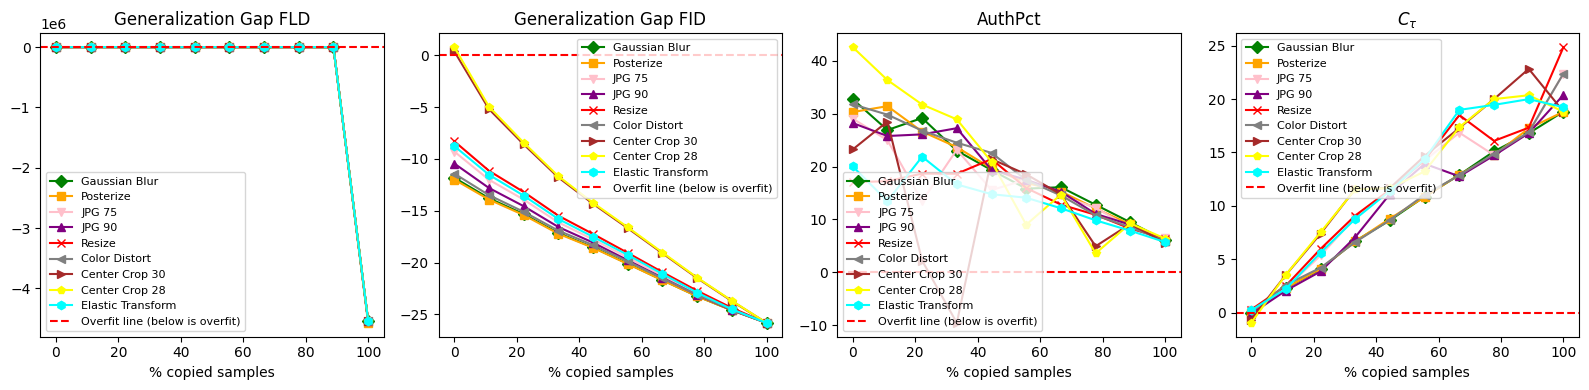

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define colors and markers for transformations
transform_styles = {
    "Original": {"color": "blue", "marker": "o"},
    "Gaussian Blur": {"color": "green", "marker": "D"},
    "Posterize": {"color": "orange", "marker": "s"},
    "JPG 75": {"color": "pink", "marker": "v"},
    "JPG 90": {"color": "purple", "marker": "^"},
    "Resize": {"color": "red", "marker": "x"},
    "Color Distort": {"color": "gray", "marker": "<"},
    "Center Crop 30": {"color": "brown", "marker": ">"},
    "Center Crop 28": {"color": "yellow", "marker": "p"},
    "Elastic Transform": {"color": "cyan", "marker": "h"}
}

# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
metrics = ["FLD Gap", "FID Gap", "AuthPct", "CT"]
titles = ["Generalization Gap FLD", "Generalization Gap FID", "AuthPct", r"$C_{\tau}$"]

for i, metric in enumerate(metrics):
    ax = axes[i]
    
    for transform_name, values in results[metric].items():
        style = transform_styles.get(transform_name, {"color": "black", "marker": "o"})
        ax.plot(copy_percentages * 100, values, label=transform_name, 
                marker=style["marker"], color=style["color"], linestyle="-")

    ax.axhline(0, linestyle="--", color="red", label="Overfit line (below is overfit)")
    ax.set_xlabel("% copied samples")
    ax.set_title(titles[i])
    ax.legend(fontsize=8, loc="best")
    
plt.tight_layout()
plt.show()
